In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))

In [2]:
import yaml
from models.bendr import EncoderConv, ContextNetwork
import torch
import yaml
import numpy as np

with open('configs/cluster_config_bendr.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

encoder_sd = torch.load('/home/ps5359/checkpoints/encoder_2024-10-08T00:17:31.296499.pt', map_location=torch.device('cpu') )
context_network_sd = torch.load('/home/ps5359/checkpoints/context_network_2024-10-08T00:17:31.296499.pt', map_location=torch.device('cpu') )


encoder = EncoderConv(**cfg['encoder'])
context_network = ContextNetwork(**cfg['context_network'])

encoder.load_state_dict(encoder_sd)
context_network.load_state_dict(context_network_sd)
encoder.eval()
context_network.eval()

/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ContextNetwork(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (target_proj): Linear(in_features=512, out_features=512, bias=True)
  (positional_emb): SinusoidalPositionalEncoding(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=False)
  )
)

In [3]:
from dataset.labeled_dataset import EEGLabeledDataset
from torch.utils.data import DataLoader

dataset = EEGLabeledDataset(
    data_path='/home/ps5359/data/full_clean/h5',
    cache_processed_path='/vast/ps5359/full_clean/cache/',
    train_length=73728, dataset_mode="full",
    rebuild_cache=False, limit=None,
    target_config={
    "user_id": True,
    "activity": False, },
    clipped_threshold=100
)
loader = DataLoader(dataset, 16, shuffle=True, drop_last=False)
next(iter(loader))['data'].shape


torch.Size([16, 4, 73728])

In [4]:
batch = next(iter(loader))
batch = encoder(batch)
batch = context_network(batch)
batch

/ext3/miniforge3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


{'data': tensor([[[-7.0795e-02,  2.4812e-01,  5.6137e-01,  ..., -2.3413e-01,
           -3.4526e-01, -5.8566e-01],
          [-5.3750e-01, -2.3752e-01,  1.3722e-01,  ..., -8.8381e-01,
           -7.3406e-01, -6.5417e-01],
          [-2.4249e-01, -2.5407e-01, -2.1118e-01,  ..., -7.2006e-01,
           -9.8884e-01, -1.2313e+00],
          [ 2.1343e-01,  2.4983e-01,  4.4903e-01,  ..., -5.8895e-01,
           -5.9907e-01, -5.1758e-01]],
 
         [[-4.3255e-01, -8.6014e-01, -7.4663e-01,  ..., -2.6734e-01,
           -1.2335e-01,  3.4264e-01],
          [ 3.8071e-01,  8.9305e-02, -1.7062e-01,  ...,  2.3784e-01,
            2.4041e-01,  1.8806e-01],
          [-3.6176e-01, -3.1704e-01, -3.6254e-01,  ...,  4.8552e-01,
            8.6504e-01,  1.0819e+00],
          [ 3.4070e-01,  2.2089e-01,  1.2541e-01,  ..., -5.5992e-01,
            5.7669e-02,  5.8638e-01]],
 
         [[ 7.7171e-02, -1.7786e-01, -4.1506e-01,  ..., -4.8756e-01,
           -1.5830e-01,  4.1669e-01],
          [ 7.7254e-01,

In [5]:
batch['context_vectors'].view(16 * 768, 512)

tensor([[-5.7606e+00,  2.0548e+00, -1.0392e+01,  ...,  1.5191e+01,
         -1.4068e+00, -1.1488e+01],
        [-1.7170e+01,  3.3739e+00, -5.5549e+00,  ..., -1.7256e+00,
          1.1897e+01, -4.4817e-01],
        [-1.9843e+01, -1.1353e+00, -1.5616e+01,  ...,  9.2416e+00,
          9.4771e+00, -4.6484e+00],
        ...,
        [-5.2450e-01, -6.5002e-01,  5.4394e-01,  ...,  8.3167e-03,
          2.6677e-02,  1.7065e+00],
        [-2.7213e-01,  1.9878e-01, -1.9008e-01,  ...,  1.2738e-01,
         -6.5344e-02,  1.6370e+00],
        [ 5.1505e-01,  4.0333e-01, -4.0358e-01,  ..., -2.4532e-02,
         -1.1925e-01,  1.5497e+00]], grad_fn=<ViewBackward0>)

In [6]:
batch['user_id']

tensor([59, 28, 47, 49, 30, 45, 18, 44, 36, 44, 44, 56, 59, 44, 48, 31])

In [7]:
(torch.arange(4).unsqueeze(1).expand(4, 768).flatten()).unique()

tensor([0, 1, 2, 3])

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import umap

@torch.no_grad()
def vis_data(vectors, groups, vis, norm):
    if norm:
        vectors = vectors / torch.norm(vectors, dim=1, keepdim=True)

    cmap = plt.get_cmap('hsv', groups.unique().size(0))  # You can choose other colormaps
    colors = {val: cmap(i) for i, val in enumerate(groups.unique().tolist())}
    color_list = [colors[val.item()] for val in groups]

    if vis == 'pca':
        u, _, _ = torch.pca_lowrank(vectors, q=2)
        emb_res = u.detach().numpy()
    elif vis == 'umap':
        reducer = umap.UMAP()
        emb_res = reducer.fit_transform(vectors.detach().numpy())
    plt.scatter(emb_res[:, 0], emb_res[:, 1], c=color_list, s=1)
    plt.title(f"{vis} norm = {norm}")
    plt.show()

In [34]:
vis_data(
    batch['context_vectors'].view(16 * 768, 512), 
    batch['user_id'].unsqueeze(1).expand(16, 768).flatten(),
    'pca',
    True,
)

RuntimeError: shape '[12288, 512]' is invalid for input of size 786432

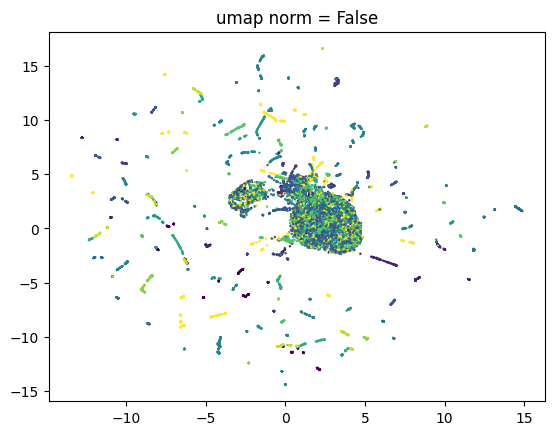

In [17]:
vis_data(
    batch['context_vectors'].view(16 * 768, 512), 
    batch['user_id'].unsqueeze(1).expand(16, 768).flatten(),
    'umap',
    False,
)

In [18]:
from tqdm import tqdm

vecs = []
uids = []


with torch.no_grad():
    for batch in tqdm(loader):
        batch = encoder(batch)
        batch = context_network(batch)
        uids.extend(batch['user_id'].tolist())
        vecs.append(batch['context_vectors'].mean(1))

  0%|          | 0/54 [00:00<?, ?it/s]/ext3/miniforge3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 54/54 [01:56<00:00,  2.16s/it]


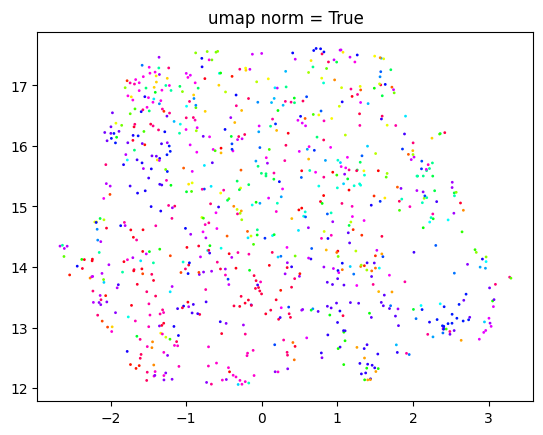

In [35]:
vis_data(
    torch.cat(vecs, 0), 
    torch.tensor(uids),
    'umap',
    True,
)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torch

def evaluate_logistic_regression(X, y, mode):
    model = LogisticRegression(max_iter=1000)
    if mode == "self":
        model.fit(X.numpy(), y.numpy())
        y_pred = model.predict(X)
        return accuracy_score(y, y_pred)
    elif mode == 'cv':
        




    accuracies = cross_val_score(model, X.numpy(), y.numpy(), cv=5, scoring='accuracy')
    return np.mean(accuracies)
    
    return accuracy

evaluate_logistic_regression(torch.cat(vecs, 0), torch.tensor(uids))

1.0